# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.058288,True,4.297665
1,0.786188,True,5.838244
2,-0.019077,False,-0.303273
3,0.802608,True,3.355919
4,-0.588180,False,-0.374269
...,...,...,...
995,-0.612186,False,0.315576
996,1.369850,True,4.745432
997,0.484971,True,5.182378
998,0.233203,False,-1.571705


<Axes: xlabel='v0'>

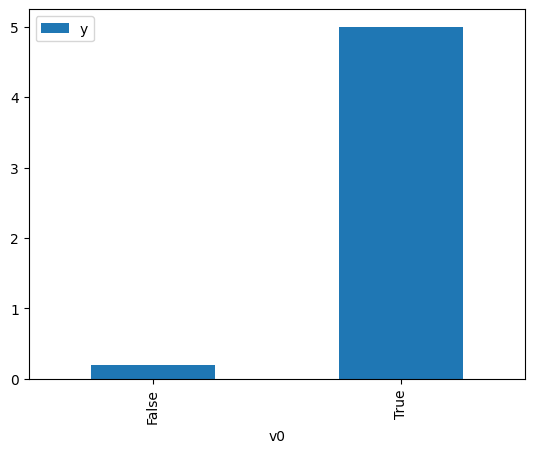

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

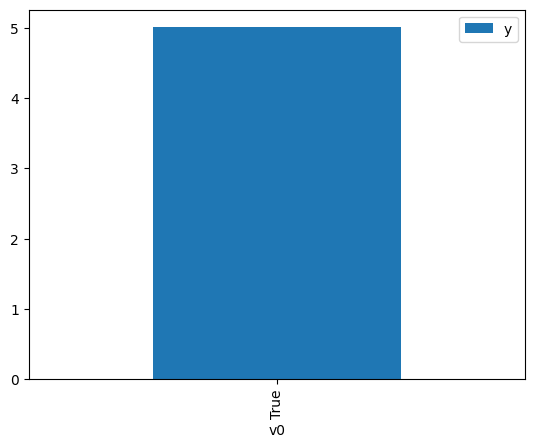

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.245639,False,-0.154512,0.647719,1.543880
1,2.354387,False,0.277032,0.019896,50.261961
2,0.282701,False,0.103917,0.423932,2.358871
3,1.365442,False,0.922272,0.101271,9.874517
4,0.541837,False,-0.160934,0.319565,3.129251
...,...,...,...,...,...
995,0.742197,False,-1.031874,0.249174,4.013253
996,0.486432,False,0.944899,0.340796,2.934303
997,-0.782919,False,-0.122438,0.823494,1.214338
998,0.908682,False,0.299059,0.199159,5.021120


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.344244,True,5.046885,0.895336,1.116899
1,1.788725,True,6.038468,0.948670,1.054107
2,-0.579176,True,5.816834,0.233780,4.277526
3,-0.393160,True,5.097190,0.296358,3.374294
4,1.339555,True,4.695352,0.894572,1.117853
...,...,...,...,...,...
995,-0.121001,True,5.837157,0.402992,2.481439
996,1.746503,True,4.551734,0.944987,1.058215
997,-0.955565,True,3.439601,0.137120,7.292892
998,1.062494,True,5.106917,0.839988,1.190494


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.946
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                              8756.
Date:                Sun, 03 Dec 2023   Prob (F-statistic):                        0.00
Time:                        08:18:38   Log-Likelihood:                         -1392.3
No. Observations:                1000   AIC:                                      2789.
Df Residuals:                     998   BIC:                                      2798.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1634      0.038      4.342      0.000       0.090       0.237
x2             4.9142      0.054     90.751      0.000       4.808       5.020
==============================================================================
Omnibus:                        0.462   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.794   Jarque-Bera (JB):                0.550
Skew:                           0.017   Prob(JB):                        0.759
Kurtosis:                       2.890   Cond. No.                         2.63
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""